<a href="https://colab.research.google.com/github/AndreaM1996/Autoencoder-for-Physical-Layer/blob/master/Gmpi_one_hot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
n = 7
k = 4
M = 2**k
R = k/n

In [0]:
def one_hot(samples, max_features):
  """
  Transforms dataset into one-hot encoding of that dataset

  samples - dataset of size (No_samples, max_length)
  max_features - maximal number of words in vocabulary
  """
  results = np.zeros((len(samples), max_features))
  for i, sample in enumerate(samples):
    results[i, sample] = 1.

  return results

# **Load data**

In [0]:
rng = np.random.default_rng()
train = rng.integers(0, M, size=16000)
val = rng.integers(0, M, size=50000)
test = rng.integers(0, M, size=100000)

In [0]:
x_train = one_hot(train, M)
x_val = one_hot(val, M)
x_test = one_hot(test, M)

# **Autoencoder**

In [0]:
def autoencoder(in_dim, n_dim, std):
  
  input_ = Input(shape=(in_dim,))
    
  # Encoder layers - Transmitter
  encoded1 = Dense(in_dim, activation='relu', name='encoder_layer1')(input_)
  encoded2 = Dense(n_dim, activation='linear', name='encoder_layer2')(encoded1)
  
  # Normalization
  normalized = Lambda(lambda x: np.sqrt(n_dim) * K.l2_normalize(x, axis=1), name='normalization')(encoded2) #energy constraint
  #normalized = Lambda(lambda x: x / K.sqrt(K.mean(x**2)), name='normalization')(encoded2) #average power enegry constraint

  # Channel
  channel = Lambda(lambda x: x + K.random_normal(shape=(n_dim,), mean=0, stddev=std, seed=42), name='channel')(normalized)

  # Decoder layers - Receiver
  decoded1 = Dense(in_dim, activation='relu', name='decoder_layer1')(channel)
  decoded2 = Dense(in_dim, activation='softmax', name='decoder_layer2')(decoded1)
  

  # Combine Encoder and Decoder layers
  autoencoder = Model(inputs = input_, outputs = decoded2)

  # Compile the Model 
  adam = optimizers.Adam(lr=0.001) 
  autoencoder.compile(optimizer = adam, loss='categorical_crossentropy',metrics=['accuracy'])
  
  encoder = Model(inputs=input_, outputs=normalized)

  return autoencoder, encoder

# **Training and performance**

In [0]:
def plot_bler_vs_ebno(blers, ebno):
  plt.figure(figsize=(6,6))
  plt.scatter(ebno, blers,label='autoencoder (8,8)')
  plt.plot
  plt.yscale('log')
  plt.xlabel('$E_b$/$N_0$ [db]', fontsize=15)
  plt.ylabel('Block error rate', fontsize=15)
  plt.legend()
  plt.show()

BLER

In [0]:
snr = range(11)
blers = []
for db in snr:
  Eb_No = 10**(db/10)
  std = math.sqrt(1/(2 * R * Eb_No))
  ae, encoder = autoencoder(M, n, std)
  history = ae.fit(x_train, x_train, epochs = 50, batch_size = 100, shuffle = True, validation_data = (x_val, x_val))
  pred = ae.predict(x_test)
  predicted = np.argmax(pred, axis=1)
  diff = np.sum(test != predicted)
  bler = diff / predicted.shape[0]
  blers.append(bler)

Epoch 1/50
160/160 [==============================] - 1s 8ms/step - loss: 2.3574 - accuracy: 0.2955 - val_loss: 1.8422 - val_accuracy: 0.5157
Epoch 2/50
160/160 [==============================] - 1s 7ms/step - loss: 1.5660 - accuracy: 0.6000 - val_loss: 1.3270 - val_accuracy: 0.6766
Epoch 3/50
160/160 [==============================] - 1s 8ms/step - loss: 1.2017 - accuracy: 0.6921 - val_loss: 1.0763 - val_accuracy: 0.7024
Epoch 4/50
160/160 [==============================] - 1s 7ms/step - loss: 0.9497 - accuracy: 0.7541 - val_loss: 0.9271 - val_accuracy: 0.7386
Epoch 5/50
160/160 [==============================] - 1s 7ms/step - loss: 0.8886 - accuracy: 0.7342 - val_loss: 0.8399 - val_accuracy: 0.7470
Epoch 6/50
160/160 [==============================] - 1s 8ms/step - loss: 0.8379 - accuracy: 0.7341 - val_loss: 0.7910 - val_accuracy: 0.7564
Epoch 7/50
160/160 [==============================] - 1s 7ms/step - loss: 0.7844 - accuracy: 0.7551 - val_loss: 0.7815 - val_accuracy: 0.7496
Epoch 

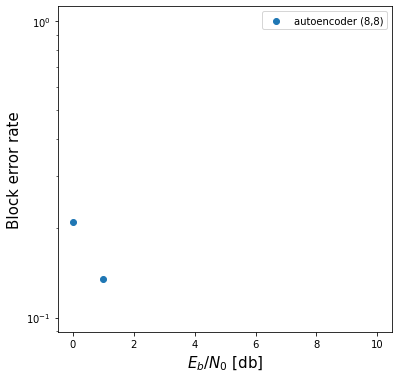

In [0]:
plot_bler_vs_ebno(blers, snr)

In [0]:
blers

[0.20974,
 0.13531,
 0.07759,
 0.04569,
 0.02518,
 0.00706,
 0.00254,
 0.00074,
 0.00019,
 0.0,
 0.0]

# Constellation

In [0]:
from sklearn.manifold import TSNE
def constellation(model, test):
  cps = model.predict(test)
  if cps.shape[1] == 2:
    x, y = zip(*cps)
  else:
    tsne = TSNE(n_components=2, perplexity=15, learning_rate=100, early_exaggeration=10, n_iter=700)
    tsne_results = tsne.fit_transform(cps)
    x, y = zip(*tsne_results)

  return x, y

def plot_constellation(x, y):
  fig, ax = plt.subplots(figsize=(6,6))
  ax.scatter(x, y, color='k', s=0.5)
  #ax.set_xlim(-2,2)
  #ax.set_ylim(-2,2)
  ax.grid()
  plt.show()

In [0]:
Eb_No_tr = 10**(7/10)
std = math.sqrt(1/(2 * R * Eb_No_tr))
ae, encoder = autoencoder(M, n, std)

In [0]:
history = ae.fit(x_train, x_train, epochs = 50, batch_size = 100, shuffle = True, validation_data = (x_val, x_val))

Epoch 1/50
160/160 [==============================] - 1s 8ms/step - loss: 2.3740 - accuracy: 0.2925 - val_loss: 1.9959 - val_accuracy: 0.4321
Epoch 2/50
160/160 [==============================] - 1s 7ms/step - loss: 1.7264 - accuracy: 0.5131 - val_loss: 1.5150 - val_accuracy: 0.5539
Epoch 3/50
160/160 [==============================] - 1s 7ms/step - loss: 1.3511 - accuracy: 0.5820 - val_loss: 1.2206 - val_accuracy: 0.5854
Epoch 4/50
160/160 [==============================] - 1s 8ms/step - loss: 1.1187 - accuracy: 0.6288 - val_loss: 1.0409 - val_accuracy: 0.6795
Epoch 5/50
160/160 [==============================] - 1s 7ms/step - loss: 0.9654 - accuracy: 0.6898 - val_loss: 0.9017 - val_accuracy: 0.6960
Epoch 6/50
160/160 [==============================] - 1s 7ms/step - loss: 0.8415 - accuracy: 0.7517 - val_loss: 0.8057 - val_accuracy: 0.7637
Epoch 7/50
160/160 [==============================] - 1s 7ms/step - loss: 0.7604 - accuracy: 0.7922 - val_loss: 0.7026 - val_accuracy: 0.8223
Epoch 

In [0]:
x, y = constellation(encoder, x_test)

In [0]:
minix = min(x)
maxix = max(x)
miniy = min(y)
maxiy = max(y)
k = [2*(xi - minix)/(maxix-minix) for xi in x]
l = [2*(xi - miniy)/(maxiy-miniy) for xi in y]

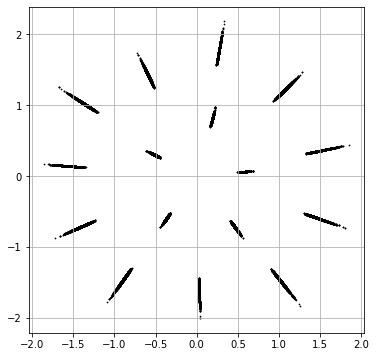

In [0]:
plot_constellation(x, y)

In [0]:
def performance(model, true):
  onehot_true = one_hot(true, M)
  y_pred = model.predict(onehot_true)
  indices = np.argmax(y_pred, axis=1)
 
  cm = confusion_matrix(true, indices)
  f1 = f1_score(true, indices, average=None)
  acc = accuracy_score(true, indices)

  df_cm = pd.DataFrame(cm)
  
  return df_cm, f1, acc

def plot_confusion_matrix(cm):
  sns.set(font_scale=0.7) # for label size
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 8})
  plt.title('Confusion matrix ')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [0]:
cm, f1, acc = performance(ae, test)

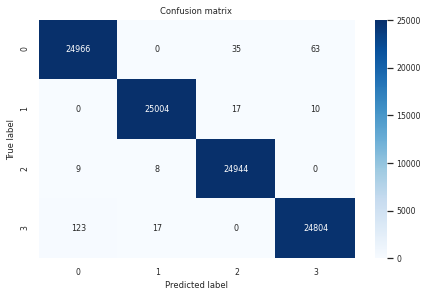

In [0]:
plot_confusion_matrix(cm)

In [0]:
f1

array([0.99541486, 0.99896125, 0.99861881, 0.99572469])

In [0]:
acc

0.99718

In [0]:
f1.sum()/len(f1)

0.9971799022389083